In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df_raw = pd.read_csv("../Morality Data/2020.csv",low_memory=False)
features= df_raw.columns.tolist()
print(features,end="，")

['restatus', 'educ1989', 'educ2003', 'educflag', 'monthdth', 'sex', 'age', 'ageflag', 'ager52', 'ager27', 'ager12', 'ager22', 'placdth', 'marstat', 'weekday', 'year', 'injwork', 'mandeath', 'methdisp', 'autopsy', 'activity', 'injury', 'ucod', 'ucr358', 'ucr113', 'ucr130', 'ucr39', 'eanum', 'econdp_1', 'econds_1', 'enicon_1', 'econdp_2', 'econds_2', 'enicon_2', 'econdp_3', 'econds_3', 'enicon_3', 'econdp_4', 'econds_4', 'enicon_4', 'econdp_5', 'econds_5', 'enicon_5', 'econdp_6', 'econds_6', 'enicon_6', 'econdp_7', 'econds_7', 'enicon_7', 'econdp_8', 'econds_8', 'enicon_8', 'econdp_9', 'econds_9', 'enicon_9', 'econdp_10', 'econds_10', 'enicon_10', 'econdp_11', 'econds_11', 'enicon_11', 'econdp_12', 'econds_12', 'enicon_12', 'econdp_13', 'econds_13', 'enicon_13', 'econdp_14', 'econds_14', 'enicon_14', 'econdp_15', 'econds_15', 'enicon_15', 'econdp_16', 'econds_16', 'enicon_16', 'econdp_17', 'econds_17', 'enicon_17', 'econdp_18', 'econds_18', 'enicon_18', 'econdp_19', 'econds_19', 'enicon_

In [3]:
df_raw.drop(columns=['ageflag', 'ager52', 'ager27', 'ager12', 'ager22','methdisp', 'autopsy','ucr358', 'ucr113', 'ucr130', 'ucr39', 'eanum', 'econdp_1',\
    'econds_1', 'enicon_1', 'econdp_2', 'econds_2', 'enicon_2', 'econdp_3', 'econds_3', 'enicon_3', 'econdp_4', 'econds_4', 'enicon_4', 'econdp_5', 'econds_5', \
        'enicon_5', 'econdp_6', 'econds_6', 'enicon_6', 'econdp_7', 'econds_7', 'enicon_7', 'econdp_8', 'econds_8', 'enicon_8', 'econdp_9', 'econds_9', 'enicon_9',\
             'econdp_10', 'econds_10', 'enicon_10', 'econdp_11', 'econds_11', 'enicon_11', 'econdp_12', 'econds_12', 'enicon_12', 'econdp_13', 'econds_13', 'enicon_13', \
                'econdp_14', 'econds_14', 'enicon_14', 'econdp_15', 'econds_15', 'enicon_15', 'econdp_16', 'econds_16', 'enicon_16', 'econdp_17', 'econds_17', 'enicon_17', \
                    'econdp_18', 'econds_18', 'enicon_18', 'econdp_19', 'econds_19', 'enicon_19', 'econdp_20', 'econds_20', 'enicon_20'])


,restatus,educ1989,educ2003,educflag,monthdth,sex,age,placdth,marstat,weekday,...,raceimp,racer3,racer5,hispanic,hspanicr,race40,occupation,occptnr,industry,indstryr
0,1,NaN,1,1,1,F,1086,1,W,6,...,NaN,2,3,100,8,3,NaN,13.0,NaN,78.0
1,1,NaN,6,1,1,M,1064,4,S,5,...,NaN,1,1,100,6,1,NaN,3.0,NaN,93.0
2,1,NaN,4,1,1,F,1039,4,D,4,...,NaN,1,1,100,6,1,NaN,11.0,NaN,81.0
3,1,NaN,3,1,1,F,1059,4,S,5,...,NaN,3,2,100,7,2,NaN,22.0,NaN,99.0
4,1,NaN,3,1,1,M,1069,2,M,4,...,NaN,1,1,100,6,1,NaN,18.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390273,1,NaN,3,1,12,M,1071,4,W,5,...,NaN,3,2,100,7,2,NaN,16.0,NaN,57.0
3390274,1,NaN,9,1,12,M,1060,4,U,2,...,1.0,3,2,998,9,2,NaN,25.0,NaN,99.0
3390275,1,NaN,9,1,12,M,1067,4,U,6,...,1.0,3,2,998,9,2,NaN,25.0,NaN,99.0
3390276,1,NaN,9,1,12,M,1054,4,U,2,...,1.0,3,2,998,9,2,NaN,NaN,NaN,NaN


In [4]:
df_raw.dropna(axis=1,how='all')
df = df_raw.fillna(0)

In [5]:
df_str = pd.DataFrame(df)
df_str['age'] = df['age'].apply(str)
age_NotSpecified = list(df_str[df_str['age'].str.contains('999')].index)
df = df.drop(index = age_NotSpecified, axis=1)
df['age'] = df['age'].apply(int)

## 1.5 Decoding the age:
#### 1. if the first digit is 1, then the last three digits represent the age under years.
#### 2. if the first digit is 2, then the last three digits represent the age under months.
#### 3. if the first digit is 4, then the last three digits represent the age under days.
#### 4. if the first digit is 5, then the last three digits represent the age under hours.
#### 5. if the first digit is 6, then the last three digits represent the age under minutes.
#### 6. if any three digits are 999, then the age is not speficied.

Here we filter out the index of keys with unspecified age, and get the index list to drop at next step.

In [6]:
df.loc[(df['age']>=1000)&(df['age']<2000),'age']= df['age'] - 1000
df.loc[(df['age']>=2000)&(df['age']<3000),'age']=(df['age']-2000)/12
df.loc[(df['age']>=4000)&(df['age']<5000),'age']=(df['age']-4000)/365
#Although we have people died when they were just a couple of hours old, we actually can ignore that since since they were that young, it is impossible for them to "commit a df"
df[(df['age']>=5000)&(df['age']<6000)]
df.loc[(df['age']>=5000)&(df['age']<6000),'age']=(df['age']-5000)/24/365
#I am so sorry that you died so young babe!
df[(df['age']>=6000)&(df['age']<7000)]
df.loc[(df['age']>=6000)&(df['age']<7000),'age']=(df['age']-6000)/60/24/365

We throw away rows with unspecified features.

In [7]:
df=df.loc[df['educ2003'] != 9]
df=df.loc[df['marstat'] != 'U']
df=df.loc[df['weekday'] != 9]
df=df.loc[df['placdth'] != 9]
df=df.loc[df['injury'] != 'U']

In [8]:
import string
import numpy as np
alphabet = list(string.ascii_uppercase)

In [9]:
ICD10_X_list = ["ICD_1_" + alpha for alpha in alphabet]

df = pd.concat([df,pd.DataFrame(columns=ICD10_X_list)])

df.update(df[ICD10_X_list].fillna(0))


In [27]:
df_suicide = df.loc[df['mandeath'] == 2]

In [28]:
def ICD10_Categorize(df_in):

    num_list=list(range(1,21,1))
    number_list=[]
    for i in num_list:
        number_list.append(str(i))
    record_list = ["record_"+ i for i in number_list]

    all_record_list=[]
    for row in df_in.itertuples():
        all_record=(getattr(row, 'record_1'), getattr(row, 'record_2'), getattr(row, 'record_3'), getattr(row, 'record_4'), getattr(row, 'record_5'), getattr(row, 'record_6'), getattr(row, 'record_7'), getattr(row, 'record_8'), getattr(row, 'record_9'), getattr(row, 'record_10'),getattr(row, 'record_11'), getattr(row, 'record_12'), getattr(row, 'record_13'), getattr(row, 'record_14'), getattr(row, 'record_15'),getattr(row, 'record_16'), getattr(row, 'record_17'), getattr(row, 'record_18'), getattr(row, 'record_19'), getattr(row, 'record_20'))
        all_record_list.append(list(all_record))

    df_record = pd.DataFrame(all_record_list)
    df_record['all_in_one']=df_record[df_record.columns[0:]].apply(lambda x: ','.join(x[x!=0].astype(str)),axis=1)

    df_out = pd.concat([df_in,df_record["all_in_one"]], axis=1, join='inner')

    for alpha in alphabet:
        df_out['ICD_1_'+alpha] = df_out['all_in_one'].str.count(alpha)

    return df_out


In [29]:
df_combined=ICD10_Categorize(df_suicide)

In [38]:
dict_ICD = {}
for i in ICD10_X_list:
    dict_ICD[i[-1]] = df_combined[i].sum()

Text(0, 0.5, 'Occurance Values')

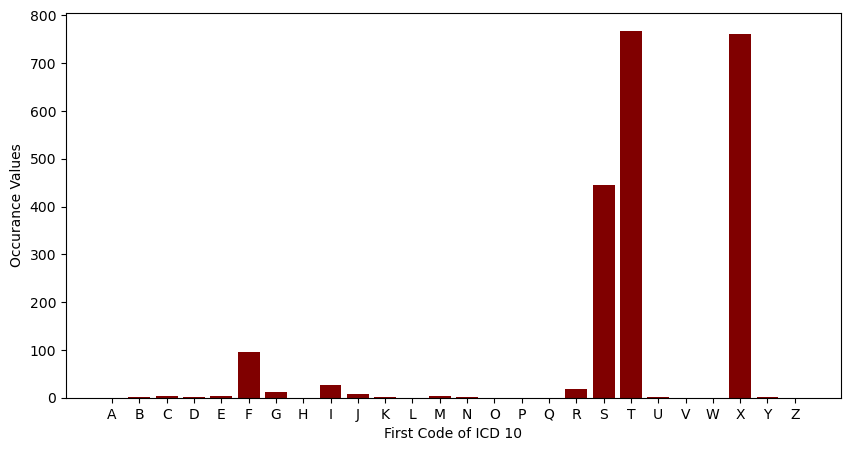

In [39]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(dict_ICD.keys(), dict_ICD.values(), color ='maroon')
plt.xlabel("First Code of ICD 10")
plt.ylabel("Occurance Values")

T and S should be outlier because it is caused by the suicides.

X is the same


In [40]:
outlier = ['X', 'S', 'T']

for key in outlier:
    del dict_ICD[key]

Text(0, 0.5, 'Occurance Values')

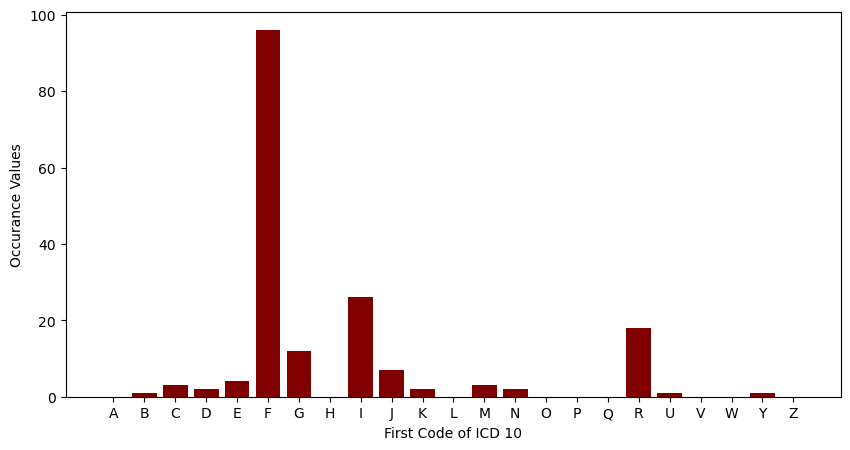

In [41]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(dict_ICD.keys(), dict_ICD.values(), color ='maroon')
plt.xlabel("First Code of ICD 10")
plt.ylabel("Occurance Values")

In [ ]:
#df.to_csv(r'../Morality Data/2020_preprocessed.csv',index=False)